<a href="https://colab.research.google.com/github/RipeNishtala/Ripe/blob/main/Copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torch_geometric networkx matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import networkx as nx
import matplotlib.pyplot as plt


In [ ]:
# Define Nodes (Drugs & Proteins)
nodes = {
    "Drug A": 0, "Drug B": 1, "Drug C": 2,  # Drugs
    "Protein X": 3, "Protein Y": 4, "Protein Z": 5  # Proteins
}

# Define Edges (Connections Between Nodes)
edges = torch.tensor([
    [0, 3], [1, 4], [2, 5],  # Drug → Protein
    [3, 4], [4, 5],  # Protein → Protein Interaction
    [0, 1], [1, 2], [0, 2]  # Drug → Drug Interaction
], dtype=torch.long).t()  # Transpose for PyTorch format

# Define Node Features (Random Features for Simplicity)
node_features = torch.rand((len(nodes), 16), dtype=torch.float)  # 16D Features per Node

# Define Labels for Drug Combinations (1 = Side Effect, 0 = No Side Effect)
edge_labels = torch.tensor([1, 0, 1, 0, 1, 1, 0, 1], dtype=torch.float)

# Create PyTorch Geometric Data Object
graph_data = Data(x=node_features, edge_index=edges, y=edge_labels)


In [ ]:
# Define Edge Prediction Model
class EdgePredictor(torch.nn.Module):
    def __init__(self, edge_input_dim):
        super(EdgePredictor, self).__init__()
        self.fc = torch.nn.Linear(edge_input_dim, 1)  # Single output for binary classification

    def forward(self, edge_embeddings):
        return torch.sigmoid(self.fc(edge_embeddings)).squeeze()  # Apply Sigmoid


In [ ]:
hidden_dim = 32  # Hidden layer size in GCN
edge_dim = hidden_dim * 2  # Since edge embeddings concatenate two node embeddings

# Initialize Models
gcn_model = DecagonGCN(input_dim=16, hidden_dim=hidden_dim)  # 16D input, 32D hidden
edge_predictor = EdgePredictor(edge_input_dim=edge_dim)  # 64D edge embeddings

# Define Optimizer & Loss Function
optimizer = torch.optim.Adam(list(gcn_model.parameters()) + list(edge_predictor.parameters()), lr=0.01)
loss_function = torch.nn.BCELoss()  # Binary Cross-Entropy for Classification


In [ ]:
# Training Loop
for epoch in range(200):
    optimizer.zero_grad()

    # Get node embeddings from GCN
    node_embeddings = gcn_model(graph_data.x, graph_data.edge_index)

    # Create edge embeddings by concatenating node representations
    edge_embeddings = torch.cat([node_embeddings[graph_data.edge_index[0]],
                                 node_embeddings[graph_data.edge_index[1]]], dim=1)

    # Get predictions
    output = edge_predictor(edge_embeddings)  # Final prediction

    # Compute loss
    loss = loss_function(output, graph_data.y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


Epoch 0: Loss = 0.7020
Epoch 20: Loss = 0.6035
Epoch 40: Loss = 0.2471
Epoch 60: Loss = 0.0440
Epoch 80: Loss = 0.0113
Epoch 100: Loss = 0.0053
Epoch 120: Loss = 0.0034
Epoch 140: Loss = 0.0025
Epoch 160: Loss = 0.0019
Epoch 180: Loss = 0.0015


In [ ]:
# Get predictions
with torch.no_grad():
    node_embeddings = gcn_model(graph_data.x, graph_data.edge_index)
    edge_embeddings = torch.cat([node_embeddings[graph_data.edge_index[0]],
                                 node_embeddings[graph_data.edge_index[1]]], dim=1)
    predictions = edge_predictor(edge_embeddings).detach().numpy()
    predicted_labels = (predictions > 0.5).astype(int)

# Print Predictions
for i, (drug_pair, label) in enumerate(zip(graph_data.edge_index.t(), predicted_labels)):
    node1, node2 = list(nodes.keys())[drug_pair[0]], list(nodes.keys())[drug_pair[1]]
    print(f"Interaction: {node1} ↔ {node2} | Predicted Side Effect: {'Yes' if label == 1 else 'No'}")


Interaction: Drug A ↔ Protein X | Predicted Side Effect: Yes
Interaction: Drug B ↔ Protein Y | Predicted Side Effect: No
Interaction: Drug C ↔ Protein Z | Predicted Side Effect: Yes
Interaction: Protein X ↔ Protein Y | Predicted Side Effect: No
Interaction: Protein Y ↔ Protein Z | Predicted Side Effect: Yes
Interaction: Drug A ↔ Drug B | Predicted Side Effect: Yes
Interaction: Drug B ↔ Drug C | Predicted Side Effect: No
Interaction: Drug A ↔ Drug C | Predicted Side Effect: Yes


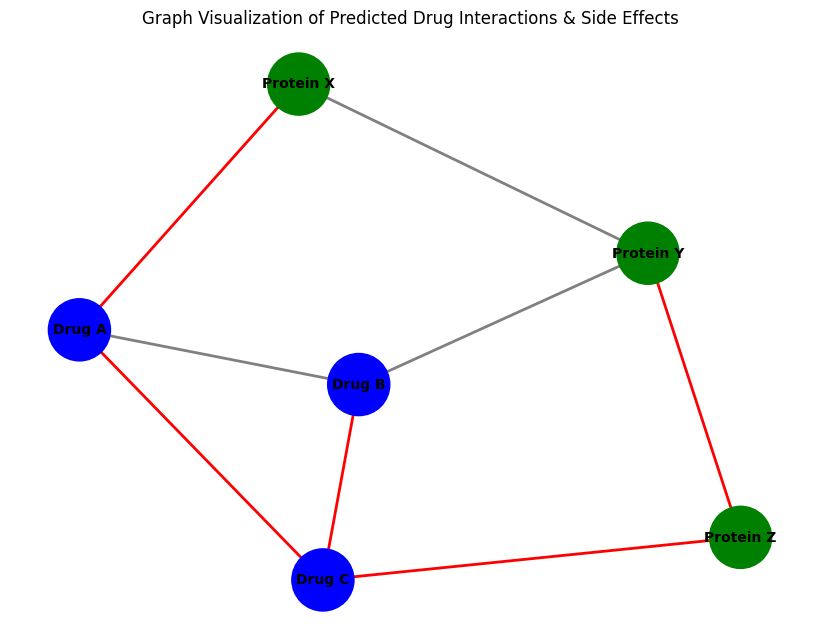

In [ ]:
# Create a NetworkX graph for visualization
G = nx.Graph()

# Add nodes with labels
for node, idx in nodes.items():
    G.add_node(node, color='blue' if 'Drug' in node else 'green')

# Add edges with predicted labels (Red if Side Effect is predicted, Gray otherwise)
edge_colors = []
for i, (node1_idx, node2_idx) in enumerate(graph_data.edge_index.t().numpy()):
    node1, node2 = list(nodes.keys())[node1_idx], list(nodes.keys())[node2_idx]
    G.add_edge(node1, node2)
    edge_colors.append('red' if predicted_labels[i] == 1 else 'gray')

# Define node colors
node_colors = [G.nodes[n]['color'] for n in G.nodes]

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors,
        node_size=2000, font_size=10, font_weight='bold', width=2)

plt.title("Graph Visualization of Predicted Drug Interactions & Side Effects")
plt.show()
